In [23]:
import pandas as pd
import missingno as msno

import psycopg2
import configparser

#### import des données

In [2]:
data = pd.read_csv('data/ecommerce-data.csv')

In [5]:
data.head()

,Date,ProductName,ProductCategory,ProductSubCategory,ProductPrice,CustomerName,CustomerEmail,CustomerAddress,CustomerPhone,CustomerSegment,...,SupplierContact,ShipperName,ShippingMethod,QuantitySold,TotalAmount,DiscountAmount,NetAmount,StockReceived,StockSold,StockOnHand
0,2023-09-14,Nathaniel,Electronics,Camera,0.01,Colleen Kelly,maryhurst@example.org,"354 Mcdowell Turnpike, Port Charles, CT 95318",908.610.2711x8507,Silver,...,6538306661,and Sons,Ground,49,31965.15,121.07,31844.08,475,127,348
1,2023-02-11,NonExistentProduct,Electronics,Mobile,847.43,Joel Wright,sandersvictoria@example.org,"24740 Fox Villages, New Tracie, MA 53038",+1-408-938-0389x952,Gold,...,NaN,PLC,Air,73,61862.39,91.09,61771.30,487,243,244
2,2021-11-12,Angela,InvalidCategory,Action Figures,386.57,Thomas Sawyer,ospence@example.net,"769 Joe Trail, East Terri, CA 43813",001-929-516-1919x39288,Gold,...,+1-588-750-7646,PLC,Sea,89,34404.73,10.56,34394.17,341,188,153
3,11-15-2021,Amy,Home & Garden,Decor,364.01,Tyler Gardner,christopherjohnson@example.com,"27783 Olivia Centers, Williamsmouth, AL 09809",8907712983,Gold,...,805-650-6257x5876,LLC,Air,3,1092.03,69.06,1022.97,500,124,376
4,2023-04-22,Nathaniel,Electronics,Camera,652.35,Meagan Peterson,epowell@example.net,"25357 Blackwell Locks, Andreabury, MH 27857",9999921886,Gold,...,6538306661,Ltd,Sea,75,48926.25,137.17,48789.08,429,351,78


#### traitement des dimentions

In [ ]:
# Extraction de la date et des éléments de temps
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
dimension_date = data[['Date']].drop_duplicates().reset_index(drop=True)
dimension_date['DateID'] = range(1, len(dimension_date) + 1)
dimension_date['Mois'] = dimension_date['Date'].dt.month
dimension_date['Trimestre'] = dimension_date['Date'].dt.quarter
dimension_date['Année'] = dimension_date['Date'].dt.year

C:\Users\sakhr\AppData\Local\Temp\ipykernel_4908\2495959940.py:4: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')


<Axes: >

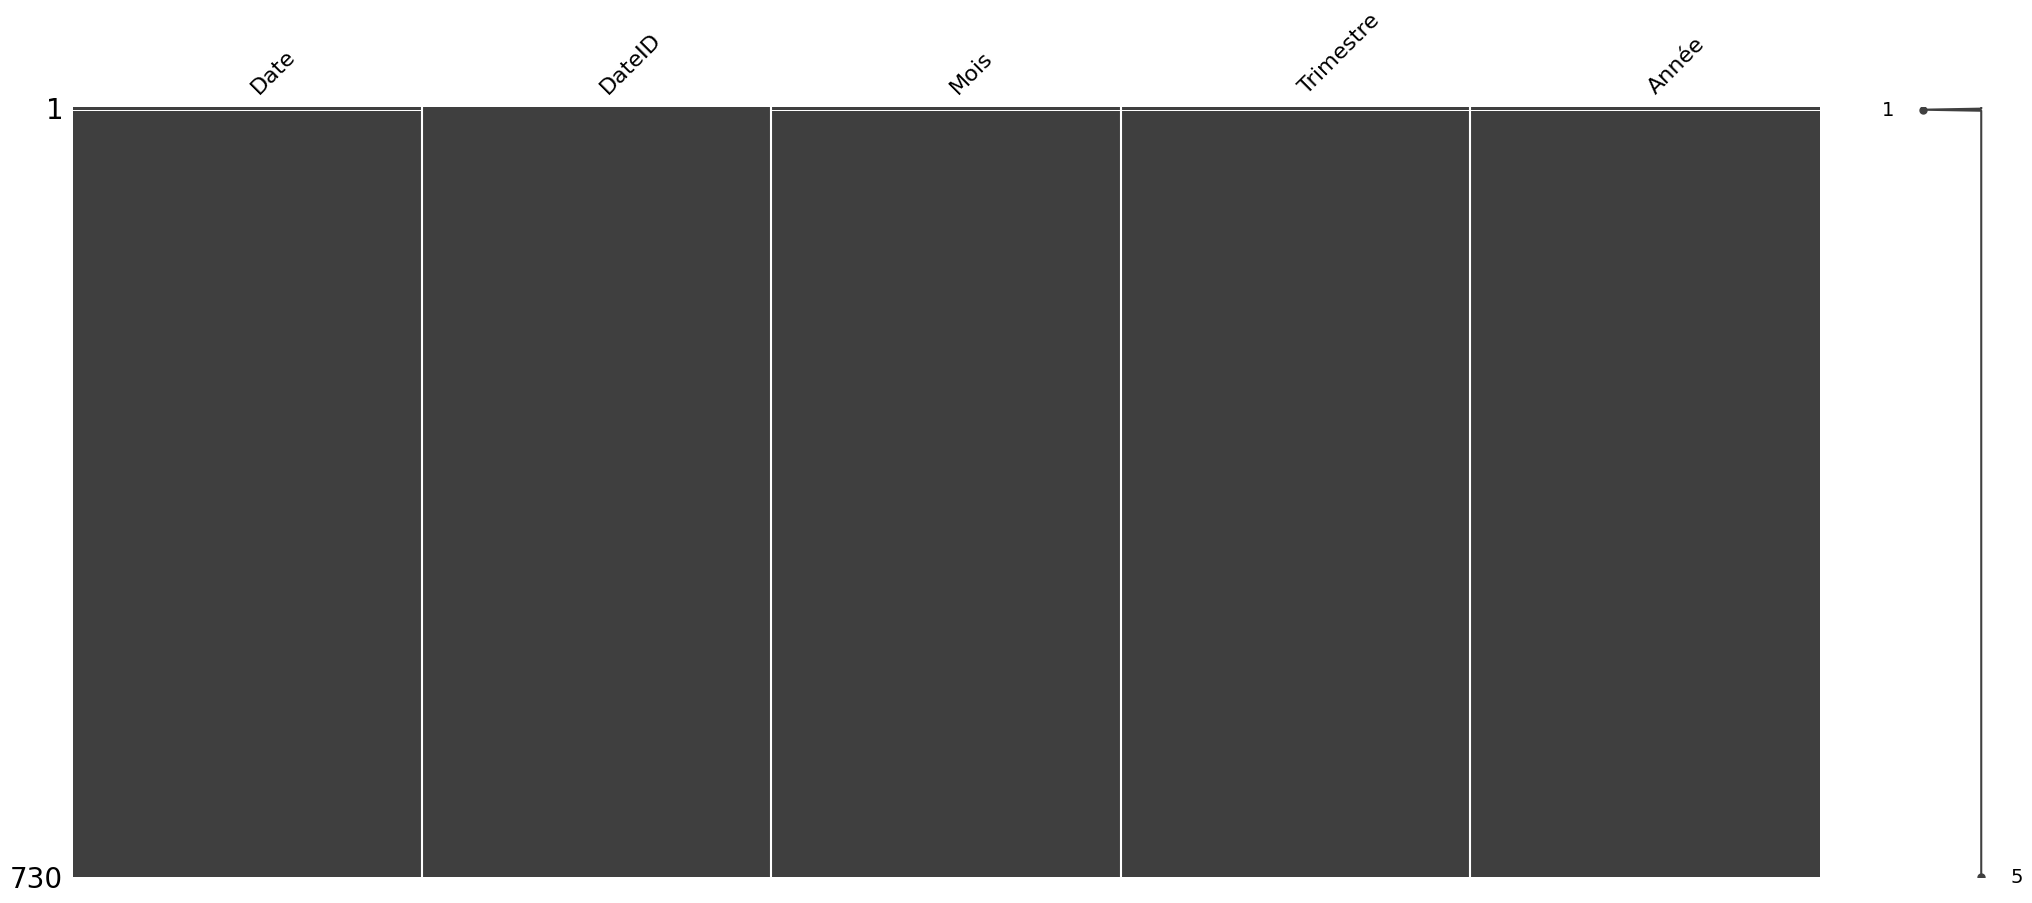

In [9]:
msno.matrix(dimension_date)

In [11]:
dimension_date.isna().sum()

Date         1
DateID       0
Mois         1
Trimestre    1
Année        1
dtype: int64

In [16]:
dimension_date

,Date,DateID,Mois,Trimestre,Année
0,2023-09-14,1,9.0,3.0,2023.0
1,2023-02-11,2,2.0,1.0,2023.0
2,2021-11-12,3,11.0,4.0,2021.0
3,2021-11-15,4,11.0,4.0,2021.0
4,2023-04-22,5,4.0,2.0,2023.0
...,...,...,...,...,...
725,2022-07-03,726,7.0,3.0,2022.0
726,2022-11-30,727,11.0,4.0,2022.0
727,2023-08-11,728,8.0,3.0,2023.0
728,2021-10-01,729,10.0,4.0,2021.0


In [ ]:
# je sais que le probleme ici vien de la date en indice 4 ou le shema n'est pas yyyy-mm-dd je fais donc le remplacement 
# a la main mais seulement parce que il n'y a que une valeu nan
dimension_date['Date'] = dimension_date['Date'].fillna(pd.to_datetime("2021-11-15"))
dimension_date['Mois'] = dimension_date['Mois'].fillna(11.0)
dimension_date['Trimestre'] = dimension_date['Trimestre'].fillna(4.0)
dimension_date['Année'] = dimension_date['Année'].fillna(2021.0)

In [17]:
# dimention produit
dimension_produit = data[['ProductName', 'ProductCategory', 'ProductSubCategory', 'ProductPrice']].drop_duplicates()
dimension_produit['ProductID'] = range(1, len(dimension_produit) + 1)

In [18]:
# dimention client
dimension_client = data[['CustomerName', 'CustomerEmail', 'CustomerAddress', 'CustomerPhone', 'CustomerSegment']].drop_duplicates()
dimension_client['CustomerID'] = range(1, len(dimension_client) + 1)

In [19]:
# dimention dournisseur
dimension_fournisseur = data[['SupplierName', 'SupplierLocation', 'SupplierContact']].drop_duplicates()
dimension_fournisseur['SupplierID'] = range(1, len(dimension_fournisseur) + 1)

In [ ]:
# table de faits
# Fusion avec les dimensions pour intégrer les clés étrangères
facts_ventes = data.merge(dimension_date[['Date', 'DateID']], on='Date', how='left')
facts_ventes = facts_ventes.merge(dimension_produit[['ProductName', 'ProductID']], on='ProductName', how='left')
facts_ventes = facts_ventes.merge(dimension_client[['CustomerName', 'CustomerID']], on='CustomerName', how='left')
facts_ventes = facts_ventes.merge(dimension_fournisseur[['SupplierName', 'SupplierID']], on='SupplierName', how='left')

# Sélection des colonnes de la table de faits qui m'interessent (choix arbitraire)
facts_ventes = facts_ventes[['DateID', 'ProductID', 'CustomerID', 'SupplierID', 'QuantitySold', 'TotalAmount', 'DiscountAmount', 'NetAmount']]

# besoin des colonnes d'id pour mes jointures, besoin des quantités vendues et des montant pour analyses calcul du chiffre d'affaire par produit par exemple

##### sauvegarde des données en csv dans un premier temps (mais pas obligatoire ...)

In [ ]:
dimension_date.to_csv("data/dimension_date.csv", index=False)
dimension_produit.to_csv("data/dimension_produit.csv", index=False)
dimension_client.to_csv("data/dimension_client.csv", index=False)
dimension_fournisseur.to_csv("data/dimension_fournisseur.csv", index=False)
facts_ventes.to_csv("data/facts_ventes.csv", index=False)

#### Sauvegarde en base de données postgresql

In [ ]:
# essayer connection avec sqlalchemy pour la connection avec ppostgresql tester ave l'orm pour optimisation (perso)

In [ ]:
# creation d'un fichier de config pour masquer les informations importantes pour la connection a ma bdd 
# ici le mot de passe n'aparait pas en claire
config = configparser.ConfigParser()
config.read('config.ini')
password = config['credentials']['password']

In [ ]:
# mise en place du connecteur
conn = psycopg2.connect(
    host="localhost",       
    database="briefRGPD", 
    user="postgres",    
    password=password, 
    port="5432"               
)

In [60]:
cur =  conn.cursor()

In [ ]:
# commande permettant de revenir en cas d'erreur de requete 
conn.rollback()

In [ ]:
# creation de la table dimension_produit dans la bdd a partir du shema de donnée (shema ici designe colonne et type)
create_dimension_produit = '''
CREATE TABLE IF NOT EXISTS dimension_produit (
    ProductID INTEGER PRIMARY KEY,
    ProductName	varchar(50),
    ProductCategory	varchar(50),
    ProductSubCategory varchar(50)
);
'''
cur.execute(create_dimension_produit)
conn.commit()

In [42]:
# table dimension_client
create_dimension_client = '''
CREATE TABLE IF NOT EXISTS dimension_client (
    CustomerName varchar(50),	
    CustomerEmail varchar(50),	
    CustomerAddress	varchar(100),
    CustomerPhone varchar(100),	
    CustomerSegment	varchar(50),
    CustomerID INTEGER PRIMARY KEY
);
'''
cur.execute(create_dimension_client)
conn.commit()

In [43]:
# table dimension_date
create_dimension_date = '''
CREATE TABLE IF NOT EXISTS dimension_date (
    Date date,	
    DateID float primary key,
    Mois float,	
    Trimestre float,
    Année float
);
'''
cur.execute(create_dimension_date)
conn.commit()

In [48]:
# table dimension_fournisseur
create_dimension_fournisseur = '''
CREATE TABLE IF NOT EXISTS dimension_fournisseur (
    SupplierName varchar(100),	
    SupplierLocation varchar(100),	
    SupplierContact	varchar(50),
    SupplierID integer primary key
);
'''
cur.execute(create_dimension_fournisseur)
conn.commit()

In [ ]:

# table de faits # specification en fin de requete des foreign keys et des table référentes
create_fact_ventes = '''
CREATE TABLE IF NOT EXISTS facts_ventes (
    DateID float,
    ProductID integer,	
    CustomerID integer,
    SupplierID integer,	
    QuantitySold integer,	
    TotalAmount	float,
    DiscountAmount float,
    NetAmount float,
    PRIMARY KEY (DateID,ProductID, SupplierID, CustomerID),
    CONSTRAINT fk_date FOREIGN KEY (DateID) REFERENCES dimension_date (DateID),
    CONSTRAINT fk_product FOREIGN KEY (ProductID) REFERENCES dimension_produit (ProductID),
    CONSTRAINT fk_supplier FOREIGN KEY (SupplierID) REFERENCES dimension_fournisseur (SupplierID),
    CONSTRAINT fk_customer FOREIGN KEY (CustomerID) REFERENCES dimension_client (CustomerID)
);
'''
cur.execute(create_fact_ventes)
conn.commit()

#### insertion des données

In [ ]:
# Insertion des données dans la table dimension_produit
for i, row in dimension_produit.iterrows():
    cur.execute("""
        INSERT INTO dimension_produit (ProductID, ProductName, ProductCategory, ProductSubCategory)
        VALUES (%s, %s, %s, %s)
    """, (row['ProductID'], row['ProductName'], row['ProductCategory'], row['ProductSubCategory']))

conn.commit()


In [ ]:
# Insertion des données dans la table dimension_client
for i, row in dimension_client.iterrows():
    cur.execute("""
        INSERT INTO dimension_client (CustomerID, CustomerName, CustomerEmail, CustomerAddress, CustomerPhone, CustomerSegment)
        VALUES (%s, %s, %s, %s, %s, %s)
    """, (row['CustomerID'], row['CustomerName'], row['CustomerEmail'], row['CustomerAddress'], row['CustomerPhone'], row['CustomerSegment']))


conn.commit()


In [ ]:
# Insertion des données dans la table dimension_date
for i, row in dimension_date.iterrows():
    cur.execute("""
        INSERT INTO dimension_date (Date, DateID, Mois, Trimestre, Année)
        VALUES (%s, %s, %s, %s, %s)
    """, (row['Date'], row['DateID'], row['Mois'], row['Trimestre'], row['Année']))


conn.commit()

In [ ]:
# Insertion des données dans la table dimension_fournisseur
for i, row in dimension_fournisseur.iterrows():
    cur.execute("""
        INSERT INTO dimension_fournisseur (SupplierID, SupplierName, SupplierLocation, SupplierContact)
        VALUES (%s, %s, %s, %s)
    """, (row['SupplierID'], row['SupplierName'], row['SupplierLocation'], row['SupplierContact']))


conn.commit()

In [ ]:
# Remplacer les valeurs NaN par une valeur par défaut, si nécessaire (par exemple 999999) 
# pour pouvoir alimenter ma table cas de force majeur
facts_ventes['DateID'] = facts_ventes['DateID'].fillna(999999)

In [ ]:
# Définir les valeurs pour la ligne avec DateID = 999999
dateid_value = 999999
date_value = '1000-01-01'  # Exemple de valeur pour dateID (erreur monumentale et visible pour simplifier 
# le travail de celui qui devra les corriger par la suite)
mois_value = 1  
trimestre_value = 1  
annee_value = 1000  

# Insérer la ligne dans dimension_date car si DateID n'aparait pas dans la table de dimention mais qu'elle est
# presente dans la table de fait une erreur sera générée d'ou l'ajout de cet id 9999999
cur.execute("""
    INSERT INTO dimension_date (DateID, Date, Mois, Trimestre, Année)
    VALUES (%s, %s, %s, %s, %s)
""", (dateid_value, date_value, mois_value, trimestre_value, annee_value))


conn.commit()

print("Ligne avec DateID = 999999 ajoutée à la table dimension_date.")

Ligne avec DateID = 999999 ajoutée à la table dimension_date.


In [85]:
# Utilisation de executemany pour insérer plusieurs lignes à la fois
cur.executemany("""
    INSERT INTO facts_ventes (DateID, ProductID, CustomerID, SupplierID, QuantitySold, TotalAmount, DiscountAmount, NetAmount)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    ON CONFLICT (DateID, ProductID, SupplierID, CustomerID) DO NOTHING
""", data_to_insert)

# Commit des changements
conn.commit()

print("Données insérées, les doublons ont été ignorés.")

Données insérées, les doublons ont été ignorés.
